# makemore: part 3

Modifying Jupyter Notebook from Andrej Karpathy for learning process.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [144]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset this is same as makemore_part2_mlp.ipynb
block_size = 8 # context length: how many characters do we take to predict the next one? Increase from 3 to 8

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


It is very important to perform initialization. If you donot do it. It will takes more time to converge and you would require lots of steps for them to reduce the loss. So it is better to perform initialization like in the below cell did with W1, b1, W2 and b2 as (5/3)/((n_embd * block_size)**0.5), 0.01, 0.01, and 0 respectively. 

Then we perform the batch normalization which is basically the x scaling where you subtract x - mean / std.dev. The scaling helps the data as normallly distributed. 

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# block_size is basically your context window. means character before that helps you predict the next character.  
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# here initialization is performed as 5/3 is the gain for Tanh. for ReLU it is different and different for other activations 
# and nemd * block_size is the fan_in and underroot https://docs.pytorch.org/docs/stable/nn.init.html Kaiming_normalization 
# this makes it in the normal distribution which same std. deviation 

# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
# b1 has been removed since when you do the batch normalization these values has been removed hpreact - bnmean_running
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 ## decreasing the W2 so that softmax function does not predict based on the weights
# Here it is done to decrease the cross entropy loss, where if we keep the uniform distribution i.e. character probability is 1 
# Then also the cross entropy loss will be 3 but when you randomly set the value using torch.randn it can provide more weights 
# which is completely wrong so for first epoch which could increase drastically the cross entropy loss to around 27. So it is 
# better to intialize W2 * 0.01 

b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
## Batch normalization is performeed so the data is in normal distribution. So if Tanh could not have very extreme value then it 
# will turn it into 1 or -1 which result in the dead neuron. 
## However this scaling is very stringent and force it become the normal distribution so we will perform scaling and shifting the values.
bngain = torch.ones((1, n_hidden)) 
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True ## require_grad basically for backpropogation. while going for forward pass it takes care of that

22097


In [7]:
C.shape, W1.shape, W2.shape

(torch.Size([27, 10]), torch.Size([80, 200]), torch.Size([200, 27]))

In [8]:
## constructing a mini batch of 32
batch_size = 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) ### index with 32 batches
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
print(Xb.shape, Yb.shape)
Xb[:20], Yb[:20]

torch.Size([32, 8]) torch.Size([32])


(tensor([[ 0,  0,  0,  0,  0,  3, 18,  5],
         [ 0, 11,  1, 25,  4,  9, 14,  3],
         [ 0,  0,  0,  0,  0,  0, 18,  1],
         [ 0,  0,  0,  0,  0,  0, 20,  1],
         [ 0,  0,  0,  0,  0,  0,  0, 20],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  4,  1, 11, 15, 20,  1],
         [ 0,  0,  0, 18,  1, 11,  1,  9],
         [ 0,  0,  0,  0,  0,  0,  0,  7],
         [ 0,  0,  0,  0,  7,  5, 14,  1],
         [ 0,  0,  0,  0,  0,  0, 10,  1],
         [ 0,  0,  0,  0,  0, 19,  1, 13],
         [ 0,  0,  0,  0,  0,  1, 12,  5],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0, 13,  9],
         [ 0,  0,  0,  0,  0, 14,  9, 25],
         [ 0,  0,  0,  0,  0,  3,  1, 12],
         [ 0,  0,  0,  0,  0,  0,  0,  1],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  3,  1]]),
 tensor([ 5,  5, 13,  9,  1, 19,  0,  0,  1, 22, 25,  5,  9, 18, 11,  1, 12, 13,
         20,  9]))

In [9]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [10]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors or flatten the vectors
hpreact = embcat @ W1 # + b1
C.shape, emb.shape, embcat.shape, W1.shape, hpreact.shape

(torch.Size([27, 10]),
 torch.Size([32, 8, 10]),
 torch.Size([32, 80]),
 torch.Size([80, 200]),
 torch.Size([32, 200]))

In [11]:
print(hpreact[:,0].mean(), hpreact[:,0].std())
print(hpreact[:,1].mean(), hpreact[:,1].std())

tensor(-1.2570, grad_fn=<MeanBackward0>) tensor(1.6069, grad_fn=<StdBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>) tensor(1.1152, grad_fn=<StdBackward0>)


In [12]:
hpreact_mean = hpreact.mean(0, keepdims = True)
hpreact_stddev = hpreact.std(0, keepdims = True)
hpreact_mean.shape, hpreact_stddev.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [13]:
### This is first neuron and second neuron
print(hpreact_mean[0,0],hpreact_mean[0,1]) 
print(hpreact_stddev[0,0], hpreact_stddev[0,1]) 

tensor(-1.2570, grad_fn=<SelectBackward0>) tensor(0.0122, grad_fn=<SelectBackward0>)
tensor(1.6069, grad_fn=<SelectBackward0>) tensor(1.1152, grad_fn=<SelectBackward0>)


In [14]:
## This is for layer normalization
hpreact_scaled = (hpreact - hpreact_mean) / hpreact_stddev

In [15]:
### Since the scaling we donot want it to be very stringent we will do scale and shift
# Since we will run it for each steps as we did for the below code. The batches will have 
# different mean, std deviation based on the sample in that particular. So it will create 
# entropy using this and work as a regularizer kind of data augmentation so it is not overfitting
hpreact_scaled = (bngain * hpreact_scaled) + bnbias

In [16]:
hpreact_scaled.shape

torch.Size([32, 200])

In [17]:
class MyClass:
    def __init__(self, eps=1e-5):
        pass

print(MyClass(eps=2))
obj = MyClass(eps=2)
print(obj.eps)

AttributeError: 'MyClass' object has no attribute 'eps'

In [18]:
class MyClass2:
    def __init__(self, eps=1e-5):
        self.eps = eps
        pass
obj = MyClass2(eps=2)
print(obj.eps)
# Parameters in the function are temporary local variables. self.eps and self.momentum store them inside the object, so they persist 
# after the function ends.


2


In [19]:
## Simple Counter  class example to illustrate the class.
class Counter:
    def __init__(self):
        self.total = 0
    def add(self,x,y):
        self.total = x + y
        return self.total
    def multiply(self,x,y):
        self.total = x * y
        return self.total
    def divide(self,x,y):
        self.total = x / y
        return self.total
    def subtract(self,x,y):
        self.total = x - y
        return self.total

In [20]:
print(torch.zeros(2).view(-1,2))
torch.ones(2).view(2,-1)

tensor([[0., 0.]])


tensor([[1.],
        [1.]])

In [21]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True ### Need to make it false during evaluation
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim) # for scaling and shifting it
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta #scaling and shifting
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
    
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------

class Flatten:
    def __init__(self):
        pass
    def __call__(self, x):
         self.out = x.view(x.shape[0], -1)
         return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential: ### Which make the layers to be sequential. This is just to make the layer to be in sequence
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x): # Input comes in: x
    # So each layer gets x only when called, not during creation.
    for layer in self.layers: # Loop through each layer
      x = layer(x) # The output of each layer becomes the input to the next
    self.out = x  # x ----> A ----> B ----> C ----> output
    return self.out # Final output is returned
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    # Loops through each layer
    # Combines all their parameters (weights/biases) into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [23]:
n_emb = 10
n_hidden = 300
## This will create the sequential layers and initialize the model parameters
model = Sequential([ 
  Embedding(vocab_size, n_emb),
  Flatten(),
  Linear(n_emb * block_size, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

32997


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # # forward pass
  # emb = C[Xb] # embed the characters into vectors
  # embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # # Linear layer
  # hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # # BatchNorm layer
  # # -------------------------------------------------------------
  # bnmeani = hpreact.mean(0, keepdim=True)
  # bnstdi = hpreact.std(0, keepdim=True)
  # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  
  # with torch.no_grad(): 
  #   # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # # -------------------------------------------------------------
  # # Non-linearity
  # h = torch.tanh(hpreact) # hidden layer
  # logits = h @ W2 + b2 # output layer
  
  # forward pass using the model
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  # Before calling loss.backward(), you must clear old gradients, otherwise gradients accumulate by default in PyTorch.
  # Equivalent to optimizer.zero_grad() when using an optimizer.
  for p in parameters:
    p.grad = None
  loss.backward()
  # Computes the gradient of the loss with respect to every parameter in the network (∂loss/∂weights).
  # Backpropagation happens here — it moves through the computation graph from the loss backward through all layers.
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  # break ### temporary break to avoid long run time

      0/ 200000: 3.3003
  10000/ 200000: 2.3064
  20000/ 200000: 1.9608
  30000/ 200000: 2.2007
  40000/ 200000: 2.2801
  50000/ 200000: 2.1223
  60000/ 200000: 1.9442
  70000/ 200000: 1.9973
  80000/ 200000: 2.0007
  90000/ 200000: 1.9075
 100000/ 200000: 2.0622
 110000/ 200000: 2.1953
 120000/ 200000: 1.8168
 130000/ 200000: 1.9207
 140000/ 200000: 1.9096
 150000/ 200000: 1.5980
 160000/ 200000: 2.0955
 170000/ 200000: 2.0450
 180000/ 200000: 2.0862
 190000/ 200000: 1.9275


In [25]:
model.layers[-1].weight.shape ### Last layer weight shape

torch.Size([300, 27])

In [26]:
print(p.shape)
print(p.data)

torch.Size([27])
tensor([-0.0849,  2.1053, -0.8084, -0.1972,  0.0289,  1.9583, -1.0420, -0.8628,
         0.3038,  0.8801, -0.9131, -0.1412,  0.9141,  0.0433,  1.1337,  0.3763,
        -0.8735, -1.7072,  0.8751,  0.9385,  0.1521, -0.6217, -0.4478, -0.8681,
        -1.4808,  1.1698, -0.8303])


In [27]:
print(p.grad.shape)
print(p.grad)

torch.Size([27])
tensor([ 0.0069,  0.0525,  0.0124, -0.0145,  0.0045, -0.0235,  0.0040,  0.0078,
        -0.0328,  0.0177,  0.0160, -0.0453, -0.0101, -0.0623, -0.0025,  0.0443,
         0.0037,  0.0005,  0.0208, -0.0030, -0.0053,  0.0131,  0.0075,  0.0031,
         0.0011,  0.0065, -0.0232])


In [28]:
parameters2 = parameters
len(parameters2)
parameters2[0].shape

torch.Size([27, 10])

In [29]:
### So data will be updated based on the gradient calculated by the backpropogation (loss.backward).
print(parameters2[1].grad.shape)
print(parameters2[1].data.shape)
print(parameters2[2].grad.shape)
print(parameters2[2].data.shape)
print(parameters2[4].grad.shape)
print(parameters2[4].data.shape)

torch.Size([80, 300])
torch.Size([80, 300])
torch.Size([300])
torch.Size([300])
torch.Size([300, 27])
torch.Size([300, 27])


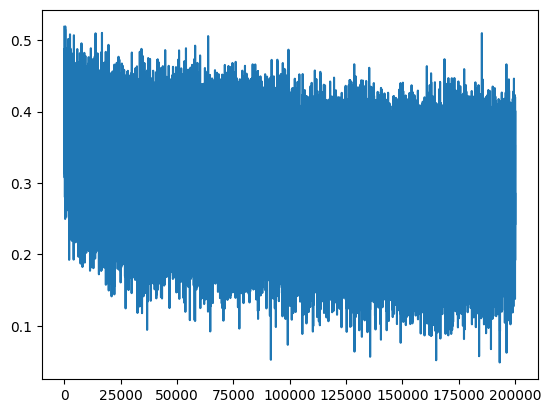

In [30]:
plt.plot(lossi)

In [31]:
len(lossi)
torch.tensor(lossi).view(-1,1000).mean(1)

tensor([0.3929, 0.3724, 0.3653, 0.3609, 0.3558, 0.3518, 0.3488, 0.3473, 0.3432,
        0.3467, 0.3411, 0.3416, 0.3376, 0.3360, 0.3356, 0.3376, 0.3323, 0.3319,
        0.3322, 0.3302, 0.3289, 0.3282, 0.3277, 0.3276, 0.3277, 0.3260, 0.3250,
        0.3256, 0.3242, 0.3237, 0.3225, 0.3216, 0.3225, 0.3214, 0.3163, 0.3200,
        0.3182, 0.3216, 0.3197, 0.3200, 0.3195, 0.3162, 0.3173, 0.3150, 0.3173,
        0.3148, 0.3153, 0.3172, 0.3129, 0.3160, 0.3158, 0.3180, 0.3140, 0.3116,
        0.3105, 0.3150, 0.3151, 0.3159, 0.3129, 0.3137, 0.3121, 0.3104, 0.3082,
        0.3108, 0.3091, 0.3135, 0.3108, 0.3108, 0.3089, 0.3107, 0.3060, 0.3114,
        0.3101, 0.3093, 0.3110, 0.3077, 0.3095, 0.3092, 0.3076, 0.3072, 0.3085,
        0.3086, 0.3059, 0.3067, 0.3048, 0.3066, 0.3071, 0.3059, 0.3091, 0.3055,
        0.3061, 0.3095, 0.3052, 0.3074, 0.3046, 0.3082, 0.3064, 0.3041, 0.3062,
        0.3021, 0.2944, 0.2862, 0.2866, 0.2856, 0.2865, 0.2877, 0.2836, 0.2835,
        0.2868, 0.2851, 0.2827, 0.2877, 

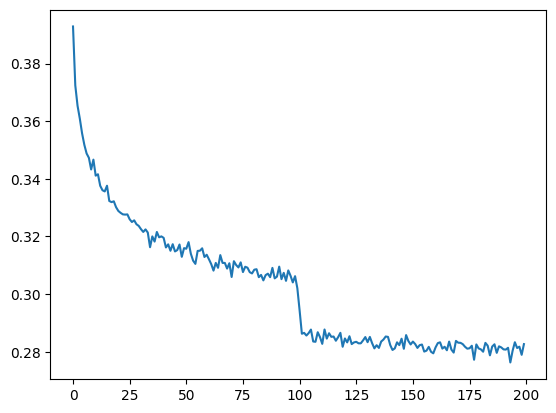

In [32]:
# making it more clean graph
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [33]:
print(model.parameters()[0].shape) # C- dimension reduction
print(model.parameters()[1].shape) # W1- weight shape
print(model.parameters()[2].shape) # gamma 
print(model.parameters()[3].shape) # Beta
print(model.parameters()[4].shape) # W2 - weight shape
print(model.parameters()[5].shape) # B2 - bias shape


torch.Size([27, 10])
torch.Size([80, 300])
torch.Size([300])
torch.Size([300])
torch.Size([300, 27])
torch.Size([27])


In [34]:
for layer in model.layers:
    layer.training = False
## In the evaluation mode the mean and std deviation is not calculated from the batch but from the running mean and std deviation
# If we are giving only one context it does not have any meaning to calculate the mean and std deviation from that single context.

In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8845244646072388
val 2.0188236236572266


In [36]:
Xtr, Xtr.shape

(tensor([[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0, 25],
         [ 0,  0,  0,  ...,  0, 25, 21],
         ...,
         [ 0,  0,  0,  ..., 15, 12,  4],
         [ 0,  0,  0,  ..., 12,  4,  1],
         [ 0,  0,  8,  ...,  4,  1, 14]]),
 torch.Size([182625, 8]))

In [37]:
x = torch.tensor([0] * block_size).unsqueeze(0) # initial context of all '.'
model(x)

tensor([[-4.4563,  1.6889,  0.7124,  0.8763,  1.0575,  0.5780, -0.5518, -0.0437,
          0.1138, -0.0980,  1.2176,  1.5654,  0.6678,  1.6272,  0.4366, -0.6174,
         -0.3091, -1.9835,  0.7951,  1.1703,  0.6696, -2.2730, -0.5703, -0.7898,
         -1.6795, -0.4234,  0.4536]], grad_fn=<AddBackward0>)

In [38]:
# print(context, logits, probs)
context = torch.tensor([0] * block_size).unsqueeze(0) # initial context of all '.'
C.shape, Xb.shape

(torch.Size([27, 10]), torch.Size([32, 8]))

In [39]:
C[Xb[0]]

tensor([[-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [ 4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01],
        [-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [-5.6144e-01, -1.3753e-01, -1.3799e-01, -2.0977e+00, -7.9238e-01,
          6.0689e-01, -1.4777e+00, -5.1029e-01,  5.6421e-01,  9.6838e-01],
        [-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [-2.4780e-01,  8.8282e-01, -8.1004e-02, -9.5299e-01, -4.8838e-01,
         -7.3712e-01,  7.0609e-01, -1.9295e-01,  1.2348e+00,  3.3308e-01],
        [ 1.2815e+00, -6.3182e-01, -1.2464e+00,  6.8305e-01, -3.9455e-01,
          1.4388e-02,  5.7216e-0

In [ ]:
C[Xb][0]

tensor([[-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [ 4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01],
        [-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [-5.6144e-01, -1.3753e-01, -1.3799e-01, -2.0977e+00, -7.9238e-01,
          6.0689e-01, -1.4777e+00, -5.1029e-01,  5.6421e-01,  9.6838e-01],
        [-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [-2.4780e-01,  8.8282e-01, -8.1004e-02, -9.5299e-01, -4.8838e-01,
         -7.3712e-01,  7.0609e-01, -1.9295e-01,  1.2348e+00,  3.3308e-01],
        [ 1.2815e+00, -6.3182e-01, -1.2464e+00,  6.8305e-01, -3.9455e-01,
          1.4388e-02,  5.7216e-0

In [122]:
C[Xb].view(Xb.shape[0], -1).shape, C[Xb].shape, C[Xb][0].shape

(torch.Size([32, 80]), torch.Size([32, 8, 10]), torch.Size([8, 10]))

In [41]:
emb = C[torch.tensor(context).unsqueeze(0)] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

/var/tmp/ipykernel_17300/3232335374.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = C[torch.tensor(context).unsqueeze(0)] # embed the characters into vectors


In [42]:
hpreact

tensor([[-2.8070, -0.4450, -1.7945,  2.2248, -0.5524,  0.3370,  0.0135, -1.3191,
         -1.2789,  1.1212,  0.1911, -2.4767,  0.2276,  0.6211,  0.3861,  0.0997,
          0.0335, -0.4219,  0.9306,  0.0177, -1.6767, -0.6968,  1.9471,  0.3431,
          1.1310, -1.5866, -0.2717,  2.6805, -1.9951, -0.3856, -0.6706, -0.3747,
          1.8246,  0.9361,  0.3819, -0.2431, -3.1336, -0.3775,  2.2578,  1.4392,
          0.1132, -1.5761, -0.1374, -2.1768, -0.0290, -0.3927, -0.2932, -1.8949,
         -3.0364,  2.0475,  0.5656, -0.6394,  1.0217,  0.5656,  3.4625, -1.1644,
         -0.7487,  0.2172,  0.3652, -1.4312,  0.6971, -1.9407,  0.6620, -0.2010,
          0.1070,  3.7203, -0.5594,  1.6682,  0.1651, -1.4544, -0.1700, -0.0198,
          0.4346,  0.2260, -0.2790,  1.2239,  0.1135,  3.5957, -0.6690, -1.7820,
          2.4612,  0.2445, -1.4350,  2.6558, -0.1232,  0.5748, -1.5346, -2.0952,
          1.1146,  0.7696,  2.9236,  1.4477, -0.8027,  1.5196,  1.1985, -0.1980,
         -0.2899, -0.7912,  

In [43]:
bnmeani = hpreact.mean(0, keepdim=True)
bnstdi = hpreact.std((0,1), keepdim=True)
bnmeani, bnstdi

(tensor([[-2.8070, -0.4450, -1.7945,  2.2248, -0.5524,  0.3370,  0.0135, -1.3191,
          -1.2789,  1.1212,  0.1911, -2.4767,  0.2276,  0.6211,  0.3861,  0.0997,
           0.0335, -0.4219,  0.9306,  0.0177, -1.6767, -0.6968,  1.9471,  0.3431,
           1.1310, -1.5866, -0.2717,  2.6805, -1.9951, -0.3856, -0.6706, -0.3747,
           1.8246,  0.9361,  0.3819, -0.2431, -3.1336, -0.3775,  2.2578,  1.4392,
           0.1132, -1.5761, -0.1374, -2.1768, -0.0290, -0.3927, -0.2932, -1.8949,
          -3.0364,  2.0475,  0.5656, -0.6394,  1.0217,  0.5656,  3.4625, -1.1644,
          -0.7487,  0.2172,  0.3652, -1.4312,  0.6971, -1.9407,  0.6620, -0.2010,
           0.1070,  3.7203, -0.5594,  1.6682,  0.1651, -1.4544, -0.1700, -0.0198,
           0.4346,  0.2260, -0.2790,  1.2239,  0.1135,  3.5957, -0.6690, -1.7820,
           2.4612,  0.2445, -1.4350,  2.6558, -0.1232,  0.5748, -1.5346, -2.0952,
           1.1146,  0.7696,  2.9236,  1.4477, -0.8027,  1.5196,  1.1985, -0.1980,
          -0.289

In [44]:
bnmeani = hpreact.mean(0, keepdim=True)
bnstdi = hpreact.std((0,1), keepdim=True)
hpreact_scaled = bngain * (hpreact - bnmeani) / bnstdi + bnbias
hpreact_scaled

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddBackward0>)

In [45]:
h = torch.tanh(hpreact) # hidden layer
h

tensor([[-0.9927, -0.4177, -0.9462,  0.9769, -0.5023,  0.3248,  0.0135, -0.8666,
         -0.8562,  0.8080,  0.1888, -0.9860,  0.2238,  0.5519,  0.3680,  0.0993,
          0.0335, -0.3985,  0.7309,  0.0177, -0.9324, -0.6023,  0.9601,  0.3302,
          0.8114, -0.9196, -0.2652,  0.9907, -0.9637, -0.3676, -0.5854, -0.3581,
          0.9493,  0.7334,  0.3644, -0.2385, -0.9962, -0.3606,  0.9784,  0.8935,
          0.1127, -0.9180, -0.1366, -0.9746, -0.0290, -0.3737, -0.2850, -0.9558,
         -0.9954,  0.9672,  0.5121, -0.5645,  0.7706,  0.5121,  0.9980, -0.8225,
         -0.6344,  0.2138,  0.3498, -0.8919,  0.6025, -0.9596,  0.5797, -0.1983,
          0.1066,  0.9988, -0.5075,  0.9313,  0.1636, -0.8966, -0.1683, -0.0198,
          0.4091,  0.2222, -0.2720,  0.8408,  0.1131,  0.9985, -0.5843, -0.9449,
          0.9855,  0.2397, -0.8927,  0.9902, -0.1226,  0.5189, -0.9112, -0.9702,
          0.8057,  0.6467,  0.9942,  0.8952, -0.6656,  0.9086,  0.8332, -0.1954,
         -0.2821, -0.6591,  

In [46]:
logits = h @ W2 + b2 # output layer
logits

tensor([[-0.0239,  0.0867,  0.1544,  0.1387, -0.1210,  0.0635,  0.0808,  0.0925,
         -0.0110, -0.0367, -0.0294, -0.0805,  0.0806, -0.0716,  0.0352,  0.1028,
         -0.1985,  0.0521, -0.0037, -0.0060, -0.0251,  0.0248,  0.1310, -0.0055,
         -0.0871,  0.0697,  0.0367]], grad_fn=<AddBackward0>)

In [47]:
logits.shape

torch.Size([1, 27])

In [48]:
probs = F.softmax(logits, dim=1)
probs

tensor([[0.0354, 0.0396, 0.0424, 0.0417, 0.0322, 0.0387, 0.0394, 0.0398, 0.0359,
         0.0350, 0.0353, 0.0335, 0.0393, 0.0338, 0.0376, 0.0402, 0.0298, 0.0382,
         0.0362, 0.0361, 0.0354, 0.0372, 0.0414, 0.0361, 0.0333, 0.0389, 0.0377]],
       grad_fn=<SoftmaxBackward0>)

In [49]:
ix = torch.multinomial(probs, num_samples=1).item()

In [50]:
len(context), emb.shape, embcat.shape, W1.shape

(1, torch.Size([1, 1, 8, 10]), torch.Size([1, 80]), torch.Size([80, 200]))

In [51]:
context

tensor([[0, 0, 0, 0, 0, 0, 0, 0]])

In [52]:
### This gives you giberish words since none of the weights are not trained on this.
# All the trained weights is in the model.
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor(context).unsqueeze(0)] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std((0,1), keepdim=True)
        hpreact_scaled = bngain * (hpreact - bnmeani) / bnstdi + bnbias
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mlycqoxtothedagetymoovqellvbemkjnbmcojdmil.
edmqfhkudrhtkwqortvjgcyajznrhwsedeyccejzoavodetnfanpc.
kkytzkgeyjavmx.
.
nyjuceyeeunyvklkwufqqckrqyznnvhpfvwmvzzybx.
ejrr.
lgtxxexqufaakegptexeoovjuepynfhlzqydhmiilquwpxw.
ipgtchqtxphatsazxjzpvxqnhazgdoepikbndrg.
ncsbguhlkzewexlrwiqwgvtazpcdcfyumyzkvktqvagyng.
zlrgykzugfdezqjmwnvsb.
byvxwyeooxhkdbclrqtln.
cmhyehyyrhlqqz.
otnvqhgrsurkbob.
gwafxzp.
vwhmvivnpxizjp.
heqaprbrzlfyn.
niwqyyuq.
kevbkkxsrwndguq.
f.
cgdp.


In [53]:
print(model.parameters()[0].shape, C.shape)
print(model.parameters()[1].shape, W1.shape)
print(model.parameters()[2].shape, bngain.shape)
print(model.parameters()[3].shape, bnbias.shape)
print(model.parameters()[4].shape, W2.shape)
print(model.parameters()[5].shape, b2.shape)

torch.Size([27, 10]) torch.Size([27, 10])
torch.Size([80, 300]) torch.Size([80, 200])
torch.Size([300]) torch.Size([1, 200])
torch.Size([300]) torch.Size([1, 200])
torch.Size([300, 27]) torch.Size([200, 27])
torch.Size([27]) torch.Size([27])


In [54]:
bnbias

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

In [55]:
model.parameters()[4]

tensor([[ 0.2923,  0.0798, -0.1085,  ...,  0.2639, -0.0053, -0.1086],
        [ 0.1953, -0.0103,  0.0540,  ...,  0.2499, -0.2487,  0.1870],
        [ 0.2847,  0.0684,  0.1345,  ...,  0.2394, -0.4745,  0.1496],
        ...,
        [ 0.0888, -0.0785,  0.0514,  ...,  0.0122, -0.0335, -0.0472],
        [-0.3268, -0.0678,  0.0181,  ..., -0.0363, -0.2923,  0.1485],
        [-0.2742, -0.1475,  0.0130,  ...,  0.1766, -0.0444,  0.1927]],
       requires_grad=True)

In [56]:
model.layers

In [57]:
context = [0] * block_size

In [58]:
for _ in range(20):
  context = [0] * block_size
  out = []
  while True:
    emb = C[torch.tensor(context).unsqueeze(0)] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std((0,1), keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

pom.
gahwdfbqvwqjqqskbcsgvxrhxxmibfkmtkggwqcgthrfmyouzeqgl.
papbhvjucinvmbsqqbosikbpxsbdshbyjqfzfcjrlfcjatroxbgfqvuxcbghbqfgfbegeoflvn.
inmihtlmec.
ttktvjzzgwmgxemebrjgfsvllgcy.
jsxxnzeiwllziavhsmswzabzdfqsihtjyoczfwcnegzoagnfpvogprfyhuohnzjagkrblcilkvpsqfehydcxgbmogtkwgsqoe.
yliugqhexzqlwbs.
rmwchuiwbtkyngcyzcuzbfqvhpgcymfpdjdtenmpsjhg.
wttclblzagatqxporiecfykyylidc.
gvewutkiabedpuw.
awnsjogmbs.
wpyrzkxammbwxlhhicpweedwnpffjj.
jowxtjzttcpzhtvke.
a.
mqmmisehshktszju.
ft.
.
qhcvnfuktwpxwrajxdbiiwwxmsszbwltwvaocb.
dfxjfkzmatktlnddpxwltkusfhgezzymykdfcjquczushnvyxfltbaqbmhslzjxnnunucelxahdqtaoc.
gdgiqilosofeekyvhszehwbrxkxptacnewwevdjmzdjggbqsolj.


In [62]:
### This gives you giberish words since none of the weights are not trained on this.
# All the trained weights is in the model.
# parameters = [C, W1, W2, b2, bngain, bnbias]
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = model.parameters()[0][torch.tensor(context).unsqueeze(0)] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ model.parameters()[1] #+ b1 # hidden layer pre-activation
        # bnmeani = hpreact.mean(0, keepdim=True)
        # bnstdi = hpreact.std((0,1), keepdim=True)
        hpreact = model.parameters()[2] * (hpreact - bnmeani) / bnstdi + model.parameters()[3]
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ model.parameters()[4] + model.parameters()[5] # output layer
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

realeen.
aoleighaous.
enaleea.
elohyaee.
esrael.
ayaei.
elouaan.
a.
aosea.
caedyn.
ee.
.
arsaa.
aa.
aamora.
aebo.
aab.
enao.
ea.
.


In [ ]:
# lets put the model weight here, currently not doing the batch normalization. It gets better
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = model.parameters()[0][torch.tensor(context).unsqueeze(0)] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ model.parameters()[1] #+ b1 # hidden layer pre-activation
        # bnmeani = hpreact.mean(0, keepdim=True)
        # bnstdi = hpreact.std((0,1), keepdim=True)
        # hpreact_scaled = bngain * (hpreact - bnmeani) / bnstdi + bnbias
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ model.parameters()[4] + model.parameters()[5] # output layer
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mhazzhav.
frtevylah.
allaikadcariebesha.
machriggttigott.
alcandenamaradfaja.
xadtcegsiquoztlextersheylard.
alrishamarzferuga.
callegtandvoanna.
dhagdonestinotiaryavlakadahjassandraleigha.
daklakthadadeg.
zailablahtegharrellyat.
lafzasnav.
jazzendydghazybah.
abigarmogel.
alhyshfukhjaaq.
aqeovannickabagdymboudastafw.
javaphwal.
qexgwva.
gallogagkayv.
alakitanahsabandralynahsrowchaddoxxreh.


In [60]:
# sample from the model
for _ in range(20):
  
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor(context).unsqueeze(0))
      # print(logits)
      probs = F.softmax(logits, dim=1)
      # print(probs)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

uzeel.
suhant.
brielli.
ivel.
dekin.
greylon.
emery.
obhid.
bringsna.
zyla.
avrata.
lecklyn.
mohammilyn.
duri.
elise.
crumyn.
jael.
tris.
file.
fraciella.


Since we are implementing the wave net model. So we have to use the bigram based model, where we input two characters to predict the next character in 4 dimension of four dimension. So suppose we have context length of 1,2,3,4,5,6,7,8. So we will divide it into (1,2),(3,4),(5,6),(7,8)

In [92]:
# so currently we have dimension in 2 dimensions
e = torch.randn(4, 8, 10)
print(e.view(4, -1, 20).shape)
(e.view(4, -1, 20) @ torch.randn(20, 5)).shape

torch.Size([4, 4, 20])


torch.Size([4, 4, 5])

Now we will change the Flatten to FlattenConsecutive. So instead of flattening all the dimensions it will flatten consecutive dimensions. So if we have 8 context and embedding dimension is 10 and we want to flatten 2 consecutive dimensions then it will become 4 and each dimension will be 20 (2*10). So the new dimension will be 4,20 instead of 4,80. This will reduce the number of parameters in the model and also help in better generalization.

In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True ### Need to make it false during evaluation
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim) # for scaling and shifting it
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta #scaling and shifting
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
    
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------

# class Flatten:
#     def __init__(self):
#         pass
#     def __call__(self, x):
#          self.out = x.view(x.shape[0], -1)
#          return self.out
#     def parameters(self):
#         return []

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n ## n is the number of consecutive tokens to be flattened 
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n) ## reshape the tensor can be written as x.view(B, -1, C * n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential: ### Which make the layers to be sequential. This is just to make the layer to be in sequence
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x): # Input comes in: x
    # So each layer gets x only when called, not during creation.
    for layer in self.layers: # Loop through each layer
      x = layer(x) # The output of each layer becomes the input to the next
    self.out = x  # x ----> A ----> B ----> C ----> output
    return self.out # Final output is returned
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    # Loops through each layer
    # Combines all their parameters (weights/biases) into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [152]:
vocab_size

27

In [201]:
n_emb = 10
n_hidden = 200
model = Sequential([ 
  Embedding(vocab_size, n_emb),
  # new layer to flatten every 2 consecutive characters
  FlattenConsecutive(2), 
  Linear(n_emb * 2, n_hidden, # layer dimensions
  bias=False),BatchNorm1d(n_hidden),Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

170897


In [202]:
Xb.shape

torch.Size([32, 8])

In [203]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) ### index with 32 batches
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
logits = model(Xb)
loss = F.cross_entropy(logits, Yb)
loss

tensor(3.3194, grad_fn=<NllLossBackward0>)

In [204]:
for layer in model.layers:
    print(layer.__class__.__name__, layer.out.shape)

Embedding torch.Size([32, 8, 10])
FlattenConsecutive torch.Size([32, 4, 20])
Linear torch.Size([32, 4, 200])
BatchNorm1d torch.Size([32, 4, 200])
Tanh torch.Size([32, 4, 200])
FlattenConsecutive torch.Size([32, 2, 400])
Linear torch.Size([32, 2, 200])
BatchNorm1d torch.Size([32, 2, 200])
Tanh torch.Size([32, 2, 200])
FlattenConsecutive torch.Size([32, 400])
Linear torch.Size([32, 200])
BatchNorm1d torch.Size([32, 200])
Tanh torch.Size([32, 200])
Linear torch.Size([32, 27])


In [188]:
vocab_size, n_emb, block_size, n_hidden, Xb.shape, Yb.shape

(27, 10, 8, 200, torch.Size([32, 8]), torch.Size([32]))

In [ ]:
emb = C[Xb]
C.shape, Xb.shape, emb.shape

(torch.Size([27, 10]), torch.Size([32, 8]), torch.Size([32, 8, 10]))

In [ ]:
print(model.layers[0].parameters()[0].shape)
model.layers

torch.Size([27, 10])


In [183]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3227
  10000/ 200000: 1.9798
  20000/ 200000: 2.3849
  30000/ 200000: 1.9915
  40000/ 200000: 2.4453
  50000/ 200000: 2.3081
  60000/ 200000: 2.1976
  70000/ 200000: 2.4639
  80000/ 200000: 2.2460
  90000/ 200000: 1.6851
 100000/ 200000: 1.8105
 110000/ 200000: 1.7708
 120000/ 200000: 2.2767
 130000/ 200000: 1.8084
 140000/ 200000: 1.4836
 150000/ 200000: 1.8008
 160000/ 200000: 2.1539
 170000/ 200000: 1.5743
 180000/ 200000: 1.6369
 190000/ 200000: 1.8008


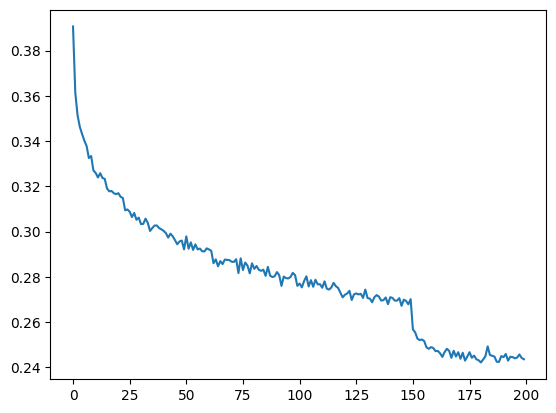

In [184]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [185]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [186]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.729549765586853
val 1.9910318851470947


In [187]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

alizee.
alivia.
ragriel.
allynn.
averyn.
yuki.
bentley.
rayna.
symon.
marcury.
senai.
andrez.
dennis.
watt.
amylarie.
avi.
gracelly.
kyre.
mishe.
emmer.


In [112]:
ix

tensor([167890, 148740,  86230, 163896,  62788,  59797,  11616,  12721,  41254,
         12631,  31256,  67211,  78578, 121966, 128479,  43306,  45969, 127582,
         58855, 141300,  56438, 161893, 116231,  25360, 133255,  88187,  78675,
         48782,  39356, 104675, 159272, 135702])

In [103]:
model.layers

In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', layer.out.shape)

Embedding : No output yet
FlattenConsecutive : No output yet
Linear : No output yet
BatchNorm1d : No output yet
Tanh : No output yet
FlattenConsecutive : No output yet
Linear : No output yet
BatchNorm1d : No output yet
Tanh : No output yet
FlattenConsecutive : No output yet
Linear : No output yet
BatchNorm1d : No output yet
Tanh : No output yet
Linear : No output yet


In [192]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

32997


In [ ]:
### This is for the evaluation mode
for layer in model.layers:
    print(layer.__class__.__name__, ':', layer.out.shape)

Embedding : torch.Size([1, 8, 10])
FlattenConsecutive : torch.Size([1, 80])
Linear : torch.Size([1, 300])
BatchNorm1d : torch.Size([1, 300])
Tanh : torch.Size([1, 300])
Linear : torch.Size([1, 27])


In [194]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2901
  10000/ 200000: 2.1561
  20000/ 200000: 2.1528
  30000/ 200000: 2.0491
  40000/ 200000: 1.9577
  50000/ 200000: 2.7128
  60000/ 200000: 2.0421
  70000/ 200000: 1.9603
  80000/ 200000: 1.6489
  90000/ 200000: 2.6339
 100000/ 200000: 2.0830
 110000/ 200000: 2.0309
 120000/ 200000: 1.8253
 130000/ 200000: 2.1281
 140000/ 200000: 1.9474
 150000/ 200000: 1.7071
 160000/ 200000: 2.1736
 170000/ 200000: 1.6425
 180000/ 200000: 1.9752
 190000/ 200000: 1.7148


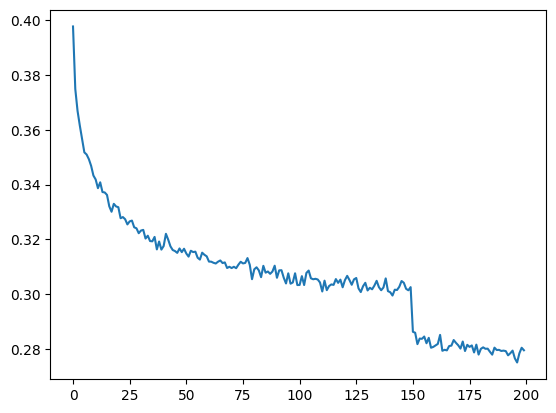

In [195]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [196]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [197]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8710064888000488
val 2.010916233062744


In [198]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

taydyn.
charlius.
calia.
lilcyn.
blentley.
lyon.
pminy.
rock.
duill.
chrisyn.
gyinvi.
cavier.
alanis.
samarian.
kionna.
sandeer.
jadich.
arileigh.
torry.
tormyn.
